In [1]:
import random

from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from matplotlib import cm 
from matplotlib import rc as mplrc

import numpy as np

import pandas as pd
import PIL

import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint, progress
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import WandbLogger, TensorBoardLogger

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
from torch import nn, Tensor
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader, Dataset, RandomSampler, random_split

import torchmetrics

# import torchvision
# import torchvision.datasets as datasets
# import torchvision.transforms as T

In [2]:
### Set seed for reproducibility
np.random.seed(123)
random.seed(123)
torch.manual_seed(123)

In [3]:
# plotting a prameters
scale_factor = 1.5

labels = 16 * scale_factor
ticks = 10 * scale_factor
# ticks = 10 * scale_factor
legends = 12 * scale_factor
text = 14 * scale_factor
titles = 22 * scale_factor
lw = 3 * scale_factor
ps = 200 * scale_factor
cmap = 'magma'

colors = ['firebrick', 'steelblue', 'darkorange', 'darkviolet', 'cyan', 'magenta', 'darkgreen', 'deeppink']
markers = ['x', 'o', '+', '>', '*', 'D', '4']
linestyles = ['-', '--', ':', '-.']

In [4]:
%load_ext tensorboard

# About

## Recurrence

Recurrent neural networks (RNNs) are the traditional (pre-transformer) way to deal with time-series/ordered data, including language. Examples include forecasting and translation. 

The key point of recurrence is that the outputs from the previous step are used as additional inputs to the current step. That is, the network takes in both typical features as well as previous predictions. The input features ($x_{t}$) and previous state ($h_{t-1}%$) go in, the recurrent block creates a hidden state vector ($h_{t}%$) that can be passed out to a prediction ($o_{t}$; perhaps going through an additional output layer) and as an additional input to the next step, $t+1$.

<img src="imgs/gru.png" style="height:400px" class="center" alt="gru"/><br>

Example of an RNN using a gated recurrent unit (GRU). This is a fairly common architecture that attempts to improve on the long short-term memomory unit (LSTM), which was one of the original methods.

The point isn't to understand the specifics within the unit, but to understand that there is a complex interplay of previous outputs (which in turn depend on the previous previous outputs, and so on) and the current inputs. This allows the unit to remember things that are important and forget things that are irrelevant.

## Embeddings

#### How do you put words into a neural network?

Neural networks take in numerical data. Obviously, words (and other features) aren't inherently numerical. We have to do something about that if we want to be able to do anything with words and neural networks.

This is where embedding comes in. In general, embedding is the process of taking data and translating it into a different space. In this case, we take words and embed them in a high-dimensional vector space.

How do we do this? Naively, we might do something like give each word some vector, perhaps by alphabetical order according to some dictionary. We could also spell the words by embedding with the alphabet. The issue here though is that embeddings gives essentially no information about the meaning of the word itself. Sure, prefixes etc. can help you infer the word's meaning, but not all words have meaningful prefixes and they often are attached to words without obvious linguistic meaning. 

We need to be more creative if we want this to work. Ideally, we will embed the words such that the embedding contains meaningful information about the word itself and its relationship with other words in the vocabulary. I don't care how a word is spelled; I care about what it means. 

A traditional way to do this is with Word2Vec. While somewhat simple, it is still powerful and fairly quick. The idea is that words are "tokenized" (this is the naive way described above), which allows them to have a unique representation, even if it's not meaningful. Using these tokens, we encode into a latent space and decode back into token space. This is often done with filling in the blank (i.e. mask a word and use the surrounding words to predict it) or skip gram (i.e. use a single word to predict the surrounding words). This is unsupervised because all you need is a bunch of sentences that you can then mask at will. When we want to pass the words through our model, we embed them into the newly trained latent space. This latent space is extraordinarily powerful and allows you to do math with words, e.g.

$$King - Man + Woman = King$$

We are now prepared to move forward with training. 

While this particular example considers words, there are other instances in which you want to do embedding. Sometimes, this doesn't require the training of an embedding network. For example, my embedding could just be a typical feature vector (this is what we will do).

## Attention

Attention has quickly become one of the most powerful concepts in machine learning. Its introduction qualitatively improved performance and led to the introduction of the transformer.

As one can imagine, RNNs can eventually "forget" old information (technically, they don't retain long-term dependencies). This can be a huge problem because the old data can contain essential context and information that is relevant to current or future predictions. Think about those super annoying recipe websites where some crucial overview is given at the top, followed by 1834890 pages of discussions on how it was received by different species of animals at different times across latitudes when the temperature of the ambient air was modified with a space heater, only eventually giving the recipe itself. The intermediate information is absolutely useless for cooking purposes. The important information is at the very beginning. As people, we have the luxury of just scrolling past all the crap, but networks have to process all of it and can forget the what we needed to remember because of all the intervening junk. We know it's not important because we've read these blogs before and hate them. The computer doesn't know this, so it may pay too much attention to the useless stuff.

Attention is a method to address this.

Remember, RNNs have a hidden state, $h_{t}$, that serves as its memory for a given time step. It is updated as the sequence is passed through the model. Traditionally, only the last hidden state is used for predictions. But why? Why not look at all of the previous hidden states? By doing that, we can see what the model thought was important going all the way back to the beginning. This allows the model to assign "attention scores" to each input, giving the model the ability to focus on specific hidden states (times) more so than others. Mathematically, these scores (call them $\alpha_{t}$) are passed through the softmax activation function (sums components to 1), making a "context vector."

$$c_{i} = \sum_{t} \alpha_{t} h_{t, i}$$

that is, the $i^{th}$ component of the context vector is the dot product of all attention scores and corresponding hidden state components. The attention process involves learning. Each component is represented by a "query vector", $Q = X \times W_{Q}$, where $X$ is the input. All other components in the sequence are represented by "key vectors", $K = X \times W_{K}$ (with appropriate scaling by $\frac{1}{d_{key}}$). All of the $W$ are learned in order to represent the queries, keys, and values in an effective manner. $Q\times K^{T}$ gives you the attention scores of the $i^{th}$ element with the $j^{th}$ key. The attention weights are calculated by applying softmax. Multiplying this matrix by the value matrix gives you the context vector.

Adding multiple attention mechanisms, i.e., multiple learnable query, key, and value matrices, can improve performance in the same way that collaborating with a team across fields can be useful. This is "multi-head attention."

By using the context vector along with the hidden state, we add the global context of the current state with respect to the entire past, thereby allowing information to flow across time or be ignored.

Another great aspect of attention is that it is easily visualized, so you can see where the network is focusing on.

Self-attention is a more advanced version that we'll get into when talking about the Transformer.

# Prepare data

In [5]:
class TimeseriesDataset(Dataset):   
    """
    We have to make this dataset a bit different than previous datasets because we are now using series
    Instead of just getting a single x, y pair, we get multiple values of X at one time 
    The legnth of that sequence is seq_length
    The output is then the y entry at the end of the sequence
    i.e, we use a series of X data to predict the final output of that sequence
    """
    def __init__(self, X: np.ndarray, y: np.ndarray, seq_length: int = 1, accelerator_name: str = "mps",):
        
        self.X = X
        self.y = y
        self.seq_length = seq_length

        if accelerator_name == "mps":
            self.device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
        elif accelerator_name == "cuda:0":
            self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        else:
            self.device = torch.device("cpu")

    def __len__(self):
        # we don't get as many sequences as there are datapoints
        return len(self.X) - (self.seq_length - 1)

    def __getitem__(self, index):

        # we grab a *sequence* rather than a single datapoint
        x_ = self.X[index:index+self.seq_length].astype(np.float32)
        
        # then get the output at the *end* of the sequence
        y_ = self.y[index+self.seq_length-1].astype(np.float32)
        
        return torch.from_numpy(x_).float().to(self.device), torch.from_numpy(np.array([y_])).float().to(self.device)

In [6]:
### we'll use a canonical time-series dataset
# https://www.kaggle.com/datasets/uciml/electric-power-consumption-data-set/
data_name = "household_power_consumption.txt"
data_dir = "./data/"

In [7]:
# load data
df = pd.read_csv(
    f"{data_dir}{data_name}", 
    sep=';', 
    parse_dates={'dt' : ['Date', 'Time']}, # merge time data entries (dd/mm/yyyy and hh:mm:ss) to get order
    dayfirst=True,
    na_values=['nan','?'], # impute with nans
    index_col='dt' # order by time
)

In [8]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [9]:
df_resample = df.resample('h').mean() # averages over each hour (reduces data and flucatuations)

In [10]:
df_resample.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667


In [11]:
# get data without any nans
X = df_resample.dropna().copy()
# remember, RNNs use previous outputs (y) as inputs
# so we don't drop the corresponding data from the input
# instead, we shift the input forward one so that
# we predict the *next* input using all current features
y = X['Global_active_power'].copy().shift(-1).ffill()

### Inspect data

In [12]:
times = list(X.index)
for i, time in enumerate(times):
    times[i] = time.value * 1e-9 # turn TimeStamp objects into typical Unix Time

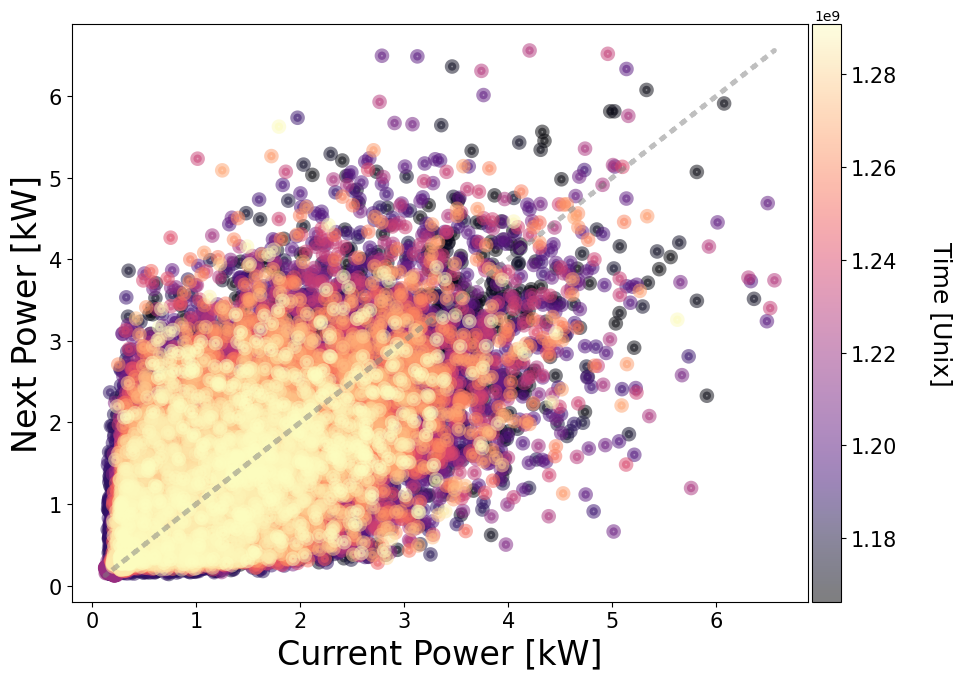

In [13]:
plt.figure(figsize=(10., 7.5))

log = False
vmin, vmax = None, None

# make a log normalizer
norm = LogNorm(vmin, vmax) if log else None

plt.scatter(X['Global_active_power'].values, y.values, lw=lw, c=times, norm=norm, alpha=0.5, cmap="magma")

plt.plot(X['Global_active_power'].values, X['Global_active_power'].values, c="gray", alpha=0.5, lw=lw-1, ls=":")

cbar = plt.colorbar(fraction=0.045, pad=0.005)
cbar.ax.set_ylabel("Time [Unix]", rotation=270, fontsize=legends)
cbar.ax.tick_params(labelsize=ticks)
cbar.ax.get_yaxis().labelpad = 40

plt.xlabel("Current Power [kW]", fontsize=labels)
plt.ylabel("Next Power [kW]", fontsize=labels)

plt.xticks(fontsize=ticks)
plt.yticks(fontsize=ticks)

plt.show()



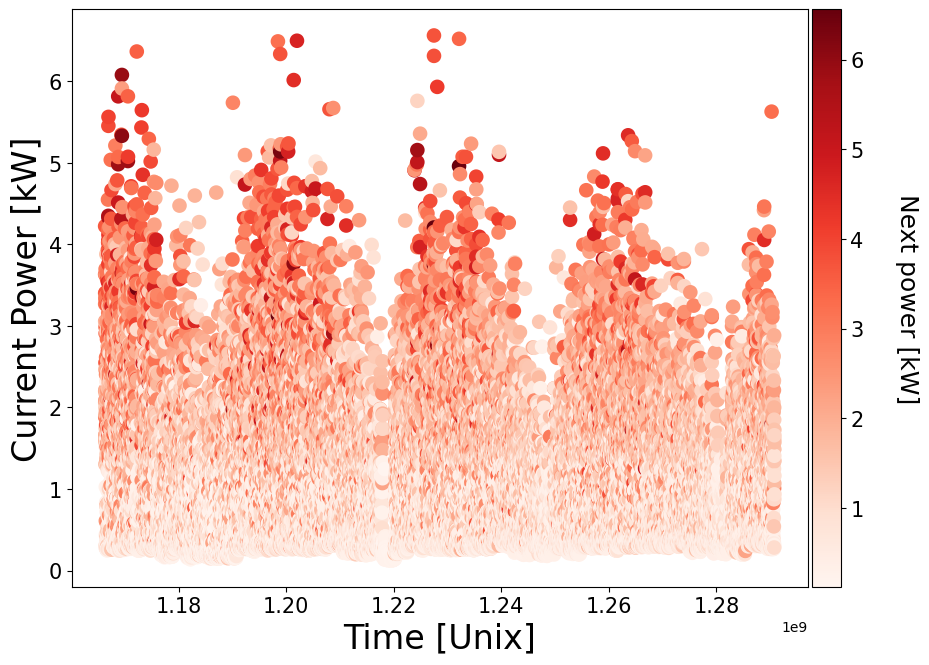

In [14]:
plt.figure(figsize=(10., 7.5))

log = False
vmin, vmax = None, None

# make a log normalizer
norm = LogNorm(vmin, vmax) if log else None

plt.scatter(times, X['Global_active_power'].values, lw=lw, c=y.values, alpha=1., cmap="Reds")

cbar = plt.colorbar(fraction=0.045, pad=0.005)
cbar.ax.set_ylabel("Next power [kW]", rotation=270, fontsize=legends)
cbar.ax.tick_params(labelsize=ticks)
cbar.ax.get_yaxis().labelpad = 40

plt.xlabel("Time [Unix]", fontsize=labels)
plt.ylabel("Current Power [kW]", fontsize=labels)


plt.xticks(fontsize=ticks)
plt.yticks(fontsize=ticks)

plt.show()

### Split data and make loaders

In [15]:
# split into validation and training data
val_split = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                   y,
                                                   test_size=val_split,
                                                   random_state=123,
                                                  )

In [16]:
# split into validation and training data
val_split = 0.2
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                   y_train,
                                                   test_size=val_split,
                                                   random_state=123,
                                                  )

In [17]:
preprocessing = StandardScaler()
preprocessing.fit(X_train)

StandardScaler()

In [18]:
X_train = preprocessing.transform(X_train)
# if type(y_train) != np.ndarray:
y_train = y_train.to_numpy()
    # y_train = y_train.values.reshape((-1, 1))
# else:
    # y_train = y_train.reshape((-1, 1))

X_val = preprocessing.transform(X_val)
# y_val = y_train.values.reshape((-1, 1))
# if type(y_train) != np.ndarray:
y_val = y_val.to_numpy()#.reshape((-1, 1))

X_test = preprocessing.transform(X_test)
# if type(y_train) != np.ndarray:
# y_test = y_train.values.reshape((-1, 1))
y_test = y_test.to_numpy()#.reshape((-1, 1))

In [19]:
batch_size = 64

In [20]:
seq_length = 1

In [21]:
accelerator_name = "mps"
# accelerator_name = "cpu"

In [22]:
##### Now we actually make the dataset and dataloader in PyTorch fashion
train_data = TimeseriesDataset(X_train, y_train, accelerator_name=accelerator_name, seq_length=seq_length)
val_data = TimeseriesDataset(X_val, y_val, accelerator_name=accelerator_name, seq_length=seq_length)
test_data = TimeseriesDataset(X_test, y_test, accelerator_name=accelerator_name, seq_length=seq_length)

# make the loader
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size) # don't shuffle order!!!!
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data)

# Define model

In [23]:
class RNN(pl.LightningModule):

    def __init__(self, 
                 num_features: int = 7,
                 seq_length = 25,
                 num_rnn_layers = 5,
                 hid_dim: int = 64,
                 dropout: float = 0.25,
                 lr: float = 1e-4, 
                 weight_decay: float = 0., 
                 eps: float = 5e-7, 
                 use_wandb: bool=False,
                 scheduler_name: str = "none",
                 step_size: int = 5,
                 gamma: float = 0.5,
                 batch_size: int = 32,
                 ) -> None:
        super().__init__()

        # this will make our lives easier because we pass tensors through multiple times
        # self.automatic_optimization = False
        
        # model parameters
        self.num_features = num_features
        self.hid_dim = hid_dim
        self.seq_length = seq_length
        self.num_rnn_layers = num_rnn_layers
        self.lr = lr
        self.eps = eps
        self.weight_decay = weight_decay
        self.dropout = dropout
        self.scheduler_name = scheduler_name
        # if using a scheduler
        self.step_size = step_size
        self.gamma = gamma

        self.batch_size = batch_size
        
        # log using WandB or TensorBoard
        self.use_wandb = use_wandb

        # what the input data looks like (allows construction of graph for logging)
        # (batch_size, channels, height, width)

        self.rnn = nn.GRU(input_size=num_features, 
                            hidden_size=hid_dim,
                            num_layers=num_rnn_layers, 
                            dropout=dropout, 
                            batch_first=True,
                          )
        self.output_layer = nn.Linear(hid_dim, 1)

        self.init_weights()

        ### initialize hidden state
        self.h = self.init_hidden(self.batch_size)

        self.example_input_array = [torch.zeros(
                                    (batch_size, self.seq_length, self.num_features),
                                    dtype=torch.float32
                                    ),
                                    self.h,
                                   ]
                     
    def init_weights(self) -> None:
        ### does some fancy layer weight initialization
        nn.init.xavier_uniform_(self.output_layer.weight)
        
    def forward(self, x, h):
        '''Determines how data is passed through the network, 
           i.e creates the connectivity of the network'''
        ### do I need to pass through hidden state?
        x, _ = self.rnn(x, h.detach()) # gets the output and hidden state
        # self.h = h.clone().to(self.device)
        return self.output_layer(nn.GELU()(x[:,-1, :]))

    def init_hidden(self, batch_size):
        return torch.zeros(self.num_rnn_layers, 
                           batch_size, 
                           self.hid_dim).float().to(self.device)

    def configure_optimizers(self) -> (list, list):
        """Set up the optimizer and potential learning rate scheduler"""
        self.optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.lr,
            eps=self.eps,
            weight_decay=self.weight_decay,
        )

        if self.scheduler_name == "none":
            return self.optimizer

        ### this decreases the learning rate by a factor of gamma every step_size
        self.scheduler = MultiStepLR(
            self.optimizer,
            list(range(0, self.trainer.max_epochs, self.step_size)),
            gamma=self.gamma,
        )

        return [self.optimizer], [{"scheduler": self.scheduler, "interval": "epoch"}]
        
    #### need to add these two things in case the scheduler is used ####
    def lr_scheduler_step(self, scheduler, metric) -> None:
        if self.scheduler_name != "none":
            self.scheduler.step()

    # def on_train_epoch_end(self):
        # """Reset hidden state after going through entire batch"""
        # self.h = self.init_hidden(self.batch_size)

    # def on_validation_epoch_end(self):
        # self.h = self.init_hidden(self.batch_size)

    # def on_test_epoch_end(self):
        # self.h = self.init_hidden(self.batch_size)

    def on_epoch_end(self) -> None:
        # self.h = self.init_hidden(self.batch_size)
        if self.scheduler_name != "none":
            self.scheduler.step()

    def process_batch(self, batch, step: str = "train"):
        """Passes and logs a batch for a given type of step (test, train, validation)"""
        
        # get data (batch includes next step, which we don't need)
        x, y = batch
        # import pdb; pdb.set_trace()

        batch_size = x.size(0)
        h = self.init_hidden(batch_size)
        # pass through network
        yhat = self(x, h)
        # import pdb; pdb.set_trace()

        # get loss
        loss = nn.MSELoss()(y, yhat)

        self.log(f"{step}_loss", loss)

        return loss
        
    def training_step(self, batch, batch_idx):
        """What do do with a training batch"""
        
        return self.process_batch(batch, step="train")

    def validation_step(self, batch, batch_idx):
        '''Validation step (at the end of each epoch)'''
        
        return self.process_batch(batch, step="val")
        
    def test_step(self, batch, batch_idx):
        
        '''Test step is essentially the same as a validation step in this instance'''
        return self.process_batch(batch, step="test")


# Initialize model

In [24]:
# model hyper parameters (fashion MNIST)
lr = 1e-3
eps = 1e-8
weight_decay = 1e-6
dropout = 0.25
hidden_dim = 48
seq_length = 25
num_features = len(X.columns)
scheduler_name = "step"
gamma = 0.5
step_size = 5
num_rnn_layers = 5

## WandB stuff
# log with WandB or TensorBoard
use_wandb = False
# do hyperparameter sweep with WandB
use_sweep = False
# WandB project name
project_name = "basic_rnn"
# WandB lab name
entity = ''

In [25]:
model = RNN(num_features=num_features,
            seq_length=seq_length,
            num_rnn_layers=num_rnn_layers,
            hid_dim=hidden_dim,
            use_wandb=use_wandb,
            dropout=dropout, 
            eps=eps, 
            lr=lr, 
            weight_decay=weight_decay,
            scheduler_name=scheduler_name,
            gamma=gamma,
            step_size=step_size,
            batch_size=batch_size,
)

# Train

In [26]:
num_epochs = 25

In [27]:
# boilerplate to get GPU if possible
if accelerator_name == "mps":
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
elif accelerator_name == "cuda":
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

In [28]:
if not use_wandb:
    # %load_ext tensorboard
    # cnn_logger = TensorBoardLogger("ae_logs", name="simple_cifar_fashion_ae")
    cnn_logger = TensorBoardLogger("rnn_logs", name="simple_rnn")
    run_name = "rnn"
else:
    logger_kwargs = {
        "resume": "allow",
        "config": model_hparams,
    }
    cnn_logger = WandbLogger(project=project_name, entity=entity, **logger_kwargs)
    cnn_run_name = cnn_logger.experiment.name

In [29]:
#### necessary for newer PTL versions
devices = 1
accelerator = "gpu" if devices == 1 else "cpu"

# make the trainer
trainer = pl.Trainer(
    devices=devices,
    accelerator=accelerator,
    max_epochs=num_epochs,
    log_every_n_steps=1,
    logger=cnn_logger,
    # reload_dataloaders_every_epoch=True,
    callbacks=[
        # ModelCheckpoint(
        #     save_weights_only=False,
        #     mode="min",
        #     monitor="val_acc",
        #     save_top_k=1,
        #     every_n_epochs=1,
        #     save_on_train_epoch_end=False,
        #     dirpath=f"/RNN_Checkpoints/{run_name}/",
        #     filename=f"rnn_checkpoint_{run_name}",
        # ),
        LearningRateMonitor("epoch"),
        progress.TQDMProgressBar(refresh_rate=1),
        EarlyStopping(
            monitor="val_loss",
            min_delta=0,
            patience=10,
            verbose=False,
            mode="min",
        ),
    ],
)
trainer.logger._log_graph = True
trainer.logger._default_hp_metric = None

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [30]:
model = model.to(device)

In [31]:
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)


  | Name         | Type   | Params | In sizes                   | Out sizes                  
---------------------------------------------------------------------------------------------------
0 | rnn          | GRU    | 64.7 K | [[64, 25, 7], [5, 64, 48]] | [[64, 25, 48], [5, 64, 48]]
1 | output_layer | Linear | 49     | [64, 48]                   | [64, 1]                    
---------------------------------------------------------------------------------------------------
64.7 K    Trainable params
0         Non-trainable params
64.7 K    Total params
0.259     Total estimated model params size (MB)
/Users/jasonterry/miniforge3/envs/pytorch_python10/lib/python3.10/site-packages/pytorch_lightning/loggers/tensorboard.py:195: UserWarning: Could not log computational graph to TensorBoard: The `input_array` or `model.example_input_array` has type <class 'list'> which can't be traced by TensorBoard. Make the input array a tuple representing the positional arguments to the model's `forw

Sanity Checking: 0it [00:00, ?it/s]

/Users/jasonterry/miniforge3/envs/pytorch_python10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/jasonterry/miniforge3/envs/pytorch_python10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

# Test

In [33]:
## Get test metrics
test_results = trainer.test(model, test_loader)
print(test_results)

/Users/jasonterry/miniforge3/envs/pytorch_python10/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.1601566076278687
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
[{'test_loss': 1.1601566076278687}]


In [47]:
## open up TensorBoard
if not use_wandb:
    %tensorboard --logdir rnn_logs --port 6003

In [35]:
def predict(model, test_loader):
    """Generate predictions for the test data."""
    
    # Ensure the model is in evaluation mode
    model.eval()

    # Initialize an empty list to collect predictions
    all_predictions = []

    with torch.no_grad():  # disable gradient computation during prediction
        for batch in test_loader:
            # Assuming batch is a tuple where the first item is the input data
            inputs = batch[0].to(torch.device("cpu"))

            # Use the model to generate predictions
            h = model.init_hidden(len(inputs)).to(torch.device("cpu"))
            predictions = model(inputs, h)

            # Store the predictions
            all_predictions.append(predictions)

    # Concatenate all predictions into a single tensor for convenience
    return torch.cat(all_predictions, dim=0)

In [36]:
y_preds = predict(model, test_loader)

In [37]:
y_preds = y_preds.detach().cpu().numpy().squeeze()

In [38]:
# inference_tensor = torch.from_numpy(X_test).float().to(device)

In [39]:
# y_preds = model(inference_tensor)

In [40]:
# y_preds = []
# for i in range(len(X_test)):
#     h = torch.zeros(model.num_rnn_layers, 1, model.hid_dim).float().to(self.device)
#     # y_pred, h = model(inference_tensor[i:i+seq_length].clone().unsqueeze(0), h)
#     y_pred = model(inference_tensor[i:i+seq_length].clone().unsqueeze(0))
#     y_preds.append(y_pred)

In [41]:
# preds = np.array([y_preds[i].detach().cpu().numpy().squeeze() for i in range(len(X_test))])

In [42]:
# trainer.predict(model, test_loader)

In [43]:
# errs = np.array([(y_test[i] - y_preds[i].squeeze()) ** 2) for i in range(len(X_test))])
errs = (y_test - y_preds) ** 2

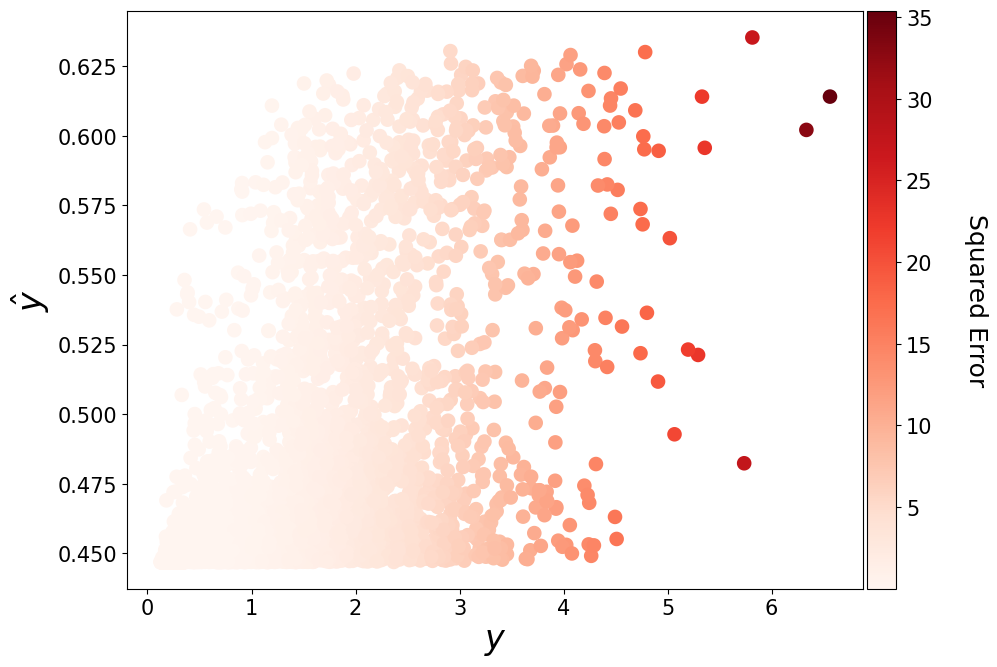

In [45]:
plt.figure(figsize=(10., 7.5))

log = False
vmin, vmax = None, None

# make a log normalizer
# norm = LogNorm(vmin, vmax) if log else None

plt.scatter(y_test, 
            y_preds, 
            lw=lw, 
            c=errs, 
            alpha=1., 
            cmap="Reds",
           )

# plt.plot(y_test, y_test, c="gray", ls=":", alpha=0.75, lw=lw)

cbar = plt.colorbar(fraction=0.045, pad=0.005)
cbar.ax.set_ylabel("Squared Error", rotation=270, fontsize=legends)
cbar.ax.tick_params(labelsize=ticks)
cbar.ax.get_yaxis().labelpad = 40

plt.xlabel(r"$y$", fontsize=labels)
plt.ylabel(r"$\hat{y}$", fontsize=labels)


plt.xticks(fontsize=ticks)
plt.yticks(fontsize=ticks)

plt.show()